# Simple Fixed Income Market

by Thomas Krabichler

## Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
images_dir=''

## Model Parameters

In [3]:
# TIME GRID

N=12*20
time_grid_plain=np.linspace(0,N,N+1)
time_grid_dcc=time_grid_plain/12 # year-count-convention

# BALANCE SHEET PARAMETERS

# assets
A0=100
# liabilities (constant deposits)
L0=50

# control the total swap volume
penalty=0.1

## Objective

In [4]:
# OPTIMISATION PARAMETERS

target_month=120

# loss function
target_equity=70

# size of training and validation set
nScenarios=10**3
nValidation=10**3

## Term Structure Model

In this section, we rely on historical ECB yield curve data. The mathematical framework of the Svensson parameterisation and the principal component analysis can be found in the Sections 3.3.3 - 3.4 of the textbook «Term Structure Models» by Damir Filipovic. Please be aware of Proposition 9.5 in the same book.

In [5]:
# YIELD CURVE PARAMETERS

index_yc=2135 # 31-Dec-2012

# YIELD CURVE DYNAMICS

# data import
path=''
ECB=pd.read_csv(images_dir+'201231_ECB.csv')

# zero-coupon bond prices for maturity T in years and Svensson parameter z
def ZCB_prices(T,z):
    return np.exp(-1/100*(z[0]*T-(z[1]/z[4]+z[2]/z[4]**2)*(np.exp(-z[4]*T)-1)-\
        z[2]/z[4]*T*np.exp(-z[4]*T)-z[3]/z[5]*T*np.exp(-z[5]*T)-z[3]/z[5]**2*\
        (np.exp(-z[5]*T)-1)))

# historical discount factors for a time grid
vec_ZCB_prices=np.vectorize(ZCB_prices,excluded=[1])

# yields for historical day i
def hist_yc(i,grid=time_grid_dcc[1:],rating='AAA'):
    shift=0 if rating=='AAA' else 6
    z=[ECB.loc[i,:][1+shift],ECB.loc[i,:][2+shift],ECB.loc[i,:][3+shift]/\
        ECB.loc[i,:][5+shift],ECB.loc[i,:][4+shift]/ECB.loc[i,:][6+shift],1/\
        ECB.loc[i,:][5+shift],1/ECB.loc[i,:][6+shift]]
    return np.divide(-np.log(vec_ZCB_prices(grid,z)),grid)

# collection of historical yields
def vec_hist_yc(i,grid=time_grid_dcc[1:],rating='AAA'):
    output=hist_yc(i[0],grid,rating)
    for j in i[1:]:
        output=np.vstack((output,hist_yc(j,grid,rating)))
    return output

# transform yields into discount factors
def discounting(yields,terms):
    return np.exp(-yields*terms)

# PCA
hist_increments=vec_hist_yc(range(1,index_yc))-vec_hist_yc(range(0,index_yc-1))
PCA_mu=np.mean(hist_increments,axis=0)
PCA_Q=np.cov(hist_increments,rowvar=False)
PCA_lambda,PCA_Lambda=np.linalg.eig(PCA_Q)
PCA_lambda,PCA_Lambda=np.real(PCA_lambda),np.real(PCA_Lambda)
#print(np.cumsum(PCA_lambda)[:10]/np.sum(PCA_lambda))

# generate a new yield curve increment
def yc_scn_gen(n=3,PCA_mu=PCA_mu,PCA_Lambda=PCA_Lambda,PCA_lambda=PCA_lambda):
    return 22*PCA_mu+np.matmul(PCA_Lambda[:,:n],np.random.multivariate_normal(\
        np.zeros(n),np.diag(22*PCA_lambda[:n])).reshape(n,1)).flatten()

# YIELD CURVE OBJECTS

class yc:
    def __init__(self,yields):
        self.yields=yields
        self.dfs=discounting(yields,time_grid_dcc[1:])
    
    def cpn(self,tenor,maturity):
        cpn_date = np.arange(tenor,maturity+tenor,tenor)  
        cpn_date_df = Y.dfs[cpn_date-1]
        return 12 / tenor * (1-Y.dfs[maturity-1]) / np.sum(cpn_date_df)
    
    def pv(self,cash_flows):
        return np.dot(self.dfs,cash_flows)
    
    def update(self,new_yields):
        self.yields=new_yields
        self.dfs=discounting(new_yields,time_grid_dcc[1:])

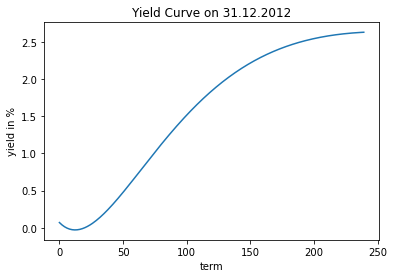

In [6]:
Y=yc(hist_yc(index_yc))
plt.plot(100*Y.yields)
plt.title('Yield Curve on '+ECB.iloc[index_yc-1,0])
plt.xlabel('term')
plt.ylabel('yield in %')
plt.show()

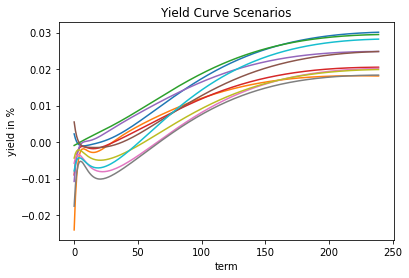

In [7]:
for k in range(int(1e1)):
    plt.plot(Y.yields+target_month*PCA_mu+np.matmul(PCA_Lambda[:,:3],\
        np.random.multivariate_normal(np.zeros(3),np.diag(target_month*\
        PCA_lambda[:3])).reshape(3,1)).flatten())
plt.title('Yield Curve Scenarios')
plt.xlabel('term')
plt.ylabel('yield in %')
plt.show()

## Swap Market

For simplicity, swap tenors in either legs are $1m$. The fixed leg is chosen such that swaps trade at par at issuance. E.g., see the section «Valuation of Interest Rate Swaps» in the textbook «Options, Futures,
and other Derivatives» by John C. Hull for further details.

In [8]:
swap_series=[24,60,120,240]
swap_num = len(swap_series)
class swap:
    def __init__(self,yc,nominal,maturity): #tenor=1
        self.yc = yc
        self.nominal = nominal
        self.maturity = maturity
        self.fixed_leg = np.append(np.repeat(yc.cpn(1,self.maturity),\
            self.maturity),np.repeat(np.zeros(1),N-self.maturity))
        self.fixed_volume = np.append(np.repeat(nominal,\
            self.maturity),np.repeat(np.zeros(1),N-self.maturity))
#         self.cash_flows = self.fixed_leg * nominal
        
    def update(self,steps=1):
        self.cash_flows=np.append(self.cash_flows[steps:],np.zeros(steps))

def swap_indicator(maturity):
    return np.reshape(np.append(np.ones(maturity),np.zeros(N-maturity)),(1,N))

In [9]:
#Test
Y = yc(hist_yc(index_yc))
s = swap(Y,0.1,240)
Y.yields[-1]

0.026313157671808297

## Benchmark Strategy of a Retail Bank

For the time being (and this can be relaxed), the deposits of the clients are kept constant and bear no interest. The asset side earns the monthly short rate. However, one could do better, if one incorporated swaps into the ecosystem. The current benchmark follows the strategy «doing nothing».

## Bank do nothing 

In [10]:
def benchmark(nRoutines=nValidation):
    np.random.seed(0)
    output=np.zeros(nRoutines)
    for l in range(nRoutines):
        # yield curve
        Y = yc(hist_yc(index_yc))
        # assets
        A = A0
        L = L0
        for k in range(target_month):
            # market updates
            A *= np.exp(Y.yields[0]/12)
            Y = yc(Y.yields+yc_scn_gen())
            E = A - L
        output[l] = E
    return output

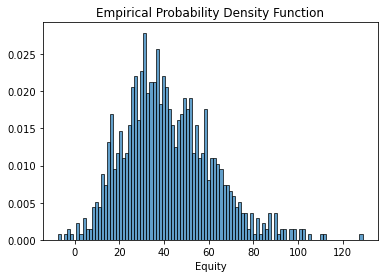

In [11]:
output_benchmark = benchmark()
plt.hist(output_benchmark,bins=100,density=True,edgecolor='black',alpha=0.7)
plt.title('Empirical Probability Density Function')
plt.xlabel('Equity')
plt.show()

## Bank with  swap trade

In [12]:
def benchmark_swap(nRoutines=nValidation):
    np.random.seed(0)
    output=np.zeros([nRoutines,target_month+1])
    for l in range(nRoutines):
        output[l,0] = A0
        # yield curve
        Y=yc(hist_yc(index_yc))
        # assets
        A = A0
        L = L0
        E = A-L
        # initial no swap
        fixed_cash_flows = np.zeros(N)
        swap_volume = np.zeros(N)
        for k in range(target_month):
            # Buy swap
            A_liq = A * 0.9 - swap_volume[k]
            for ith, swap_maturity in enumerate(swap_series):
                if target_month - k >= swap_maturity:
                    swap_nominal = A_liq * 0.05
                    s = swap(Y,1,swap_maturity)
                    fixed_cash_flows[k:] += s.fixed_leg[:N-k] * swap_nominal
                    swap_volume[k:] += s.fixed_volume[:N-k] * swap_nominal
            # Market update
            A += (A - swap_volume[k])*(np.exp(Y.yields[0]/12)-1) + fixed_cash_flows[k] 
            E = A-L
            Y = yc(Y.yields+yc_scn_gen())
            output[l,k+1] = A
        
    return output

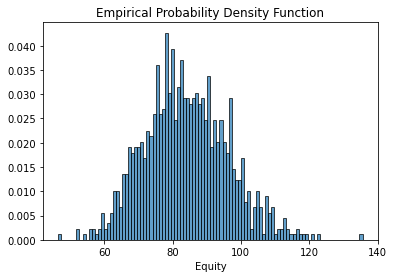

In [13]:
output_benchmark_swap = benchmark_swap()
helper = output_benchmark_swap[:,-1]-L0
plt.hist(helper,bins=100,density=True,edgecolor='black',alpha=0.7)
plt.title('Empirical Probability Density Function')
plt.xlabel('Equity')
plt.show()

# Deep Learning

In [14]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
keras = tf.keras
from importlib import reload 
print(tf.__version__)

2.3.0


In [15]:
def build_network(n_output, n_hidden, depth, time_steps):
# architecture is the same for all networks
    Networks = []
    for j in range(time_steps):
        inputs = keras.Input(shape=(1))
        layer = keras.layers.Dense(n_output, activation = 'sigmoid') # make sure output <= 1
        outputs = layer(inputs) * 0.25 # make sure the sum less than 1 because there are 4 swaps 
        network = keras.Model(inputs = inputs, outputs = outputs)
        Networks.append(network)
    return Networks

In [16]:
Networks = build_network(4,1,1, target_month) 
print(len(Networks))
Networks[11].summary()

120
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 8         
_________________________________________________________________
tf_op_layer_Mul_11 (TensorFl [(None, 4)]               0         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [17]:
a = target_month - np.arange(N) # months to target month
b = np.array([swap_series]).T # maturity 
c = (a >= b).T
maturity_leq_target = tf.constant(c,dtype = 'float32')  # indicate if maturity month ealier than target month

In [18]:
def prepare_data(nRoutines = nValidation):
    np.random.seed(0)
    yields_data = np.zeros([nRoutines,target_month])
    swap_rate_data = np.zeros([nRoutines,target_month,len(swap_series),N])
    swap_volume_data = np.zeros([nRoutines,target_month,len(swap_series),N])
    for l in range(nRoutines):
        Y=yc(hist_yc(index_yc))
        for k in range(target_month):
            yields_data[l,k] = Y.yields[0] 
            for ith, swap_maturity in enumerate(swap_series):
                s = swap(Y,1,swap_maturity)
                swap_rate_data[l,k,ith,k:] = s.fixed_leg[:N-k] 
                swap_volume_data[l,k,ith,k:] = s.fixed_volume[:N-k] 
            Y=yc(Y.yields+yc_scn_gen())
    inputs_X = [yields_data, swap_rate_data, swap_volume_data]
    inputs_Y = np.zeros([nRoutines]) + target_equity 
    return inputs_X, inputs_Y

In [19]:
def build_graph():
    yields_data = keras.Input(shape=(target_month)) 
    swap_rate_data = keras.Input(shape=(target_month,swap_num,N))
    swap_volume_data = keras.Input(shape=(target_month,swap_num,N))
    batch_size = tf.shape(yields_data)[0]
    
    A = tf.zeros(batch_size) + A0 
    L = tf.zeros(batch_size) + L0
    fixed_cash_flows = tf.zeros([batch_size,N])
    swap_volume = tf.zeros([batch_size,N])
    
    A_list = [None] * (target_month+1)
    A_liq_list = [] # Just to record if we break restriction 
    A_list[0] = A 
    
    for k in range(target_month):
        # Before rebalance 
        A_liq = 0.9 * A_list[k] - swap_volume[:,k]
        A_liq_list.append(A_liq)
        strategy = Networks[k](tf.zeros([batch_size,1])) * tf.tile(A_liq[:,None],[1,4]) * maturity_leq_target[k]
        fixed_cash_flows += tf.reduce_sum(swap_rate_data[:,k,:,:] * strategy[:,:,None], axis = 1)
        swap_volume += tf.reduce_sum(swap_volume_data[:,k,:,:] * strategy[:,:,None], axis = 1)
        # Market update
        A_list[k+1] = A_list[k] + (A_list[k] - swap_volume[:,k])*(tf.exp(yields_data[:,k]/12) - 1) + fixed_cash_flows[:,k]
    E = A_list[-1] - L    
    
    inputs = [yields_data, swap_rate_data, swap_volume_data]
    outputs = E
    model = keras.Model(inputs = inputs, outputs = outputs)
    
    mse = tf.keras.losses.MeanSquaredError()
    target_E = tf.zeros(batch_size) + target_equity
    model.add_loss(mse(E,target_E))
    
    cons_loss = 0
    for A_liq in A_liq_list:
        cons_loss += tf.nn.relu(-A_liq)
    cons_loss = tf.reduce_mean(cons_loss)
    model.add_loss(cons_loss)
    model.add_metric(cons_loss, name='restriction_loss')
    
    return model

model = build_graph()
# model.summary()

In [20]:
inputs_X, inputs_Y = prepare_data()

In [21]:
def zeroloss(y_true, y_predict):
            return tf.reduce_sum(y_true*0)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # specify the optmizer 
model.compile(optimizer = optimizer, loss=zeroloss) 

In [22]:
model.fit(x=inputs_X, y = inputs_Y, epochs = 15, verbose = 1)

Epoch 1/15
32/32 [==============================] - 3s 83ms/step - loss: 1050.6542 - restriction_loss: 0.0000e+00
Epoch 2/15
32/32 [==============================] - 2s 72ms/step - loss: 661.7228 - restriction_loss: 0.0000e+00
Epoch 3/15
32/32 [==============================] - 2s 63ms/step - loss: 403.0435 - restriction_loss: 0.0000e+00
Epoch 4/15
32/32 [==============================] - 2s 64ms/step - loss: 249.6521 - restriction_loss: 0.0000e+00
Epoch 5/15
32/32 [==============================] - 2s 61ms/step - loss: 165.0785 - restriction_loss: 0.0000e+00
Epoch 6/15
32/32 [==============================] - 2s 62ms/step - loss: 119.3974 - restriction_loss: 0.0000e+00
Epoch 7/15
32/32 [==============================] - 2s 66ms/step - loss: 93.5830 - restriction_loss: 0.0000e+00
Epoch 8/15
32/32 [==============================] - 2s 64ms/step - loss: 79.3041 - restriction_loss: 0.0000e+00
Epoch 9/15
32/32 [==============================] - 2s 69ms/step - loss: 70.7663 - restriction_lo

In [24]:
yields_data, swap_rate_data, swap_volume_data = inputs_X
yields_data = yields_data.astype('float32')
swap_rate_data = swap_rate_data.astype('float32')
swap_volume_data = swap_volume_data.astype('float32')

batch_size = tf.shape(yields_data)[0]
    
A = tf.zeros(batch_size) + A0 
L = tf.zeros(batch_size) + L0
fixed_cash_flows = tf.zeros([batch_size,N])
swap_volume = tf.zeros([batch_size,N])

A_list = [None] * (target_month+1)
A_liq_list = [] # Just to record if we break restriction 
A_list[0] = A 

for k in range(target_month):
    # Before rebalance 
    A_liq = 0.9 * A_list[k] - swap_volume[:,k]
    A_liq_list.append(A_liq)
    strategy = Networks[k](tf.zeros([batch_size,1])) * tf.tile(A_liq[:,None],[1,4]) * maturity_leq_target[k]
    fixed_cash_flows += tf.reduce_sum(swap_rate_data[:,k,:,:] * strategy[:,:,None], axis = 1)
    swap_volume += tf.reduce_sum(swap_volume_data[:,k,:,:] * strategy[:,:,None], axis = 1)
    # Market update
    A_list[k+1] = A_list[k] + (A_list[k] - swap_volume[:,k])*(tf.exp(yields_data[:,k]/12) - 1) + fixed_cash_flows[:,k]
E = A_list[-1] - L   

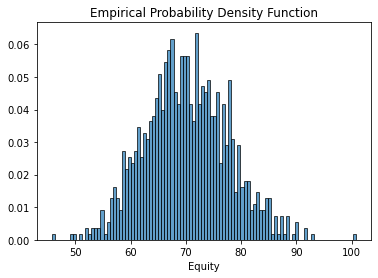

In [25]:
plt.hist(E.numpy(),bins=100,density=True,edgecolor='black',alpha=0.7)
plt.title('Empirical Probability Density Function')
plt.xlabel('Equity')
plt.show()

In [27]:
A_flow = np.array(A_list).T
tf.reduce_min(A_flow[:,1:]*0.9 - swap_volume[:,:120]).numpy() > 0

True